---
title: 02 - human integration
author: Martin Proks
date: 26-08-2023
---

In [1]:
!which pip

~/projects/data/Brickman/conda/envs/scvi-1.0.0/bin/pip


In [2]:
import scvi
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt


from rich import print
from scib_metrics.benchmark import Benchmarker
from scvi.model.utils import mde


import warnings
from lightning_fabric.plugins.environments.slurm import PossibleUserWarning
warnings.simplefilter(action='ignore', category=PossibleUserWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

scvi.settings.seed = 42

/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[rank: 0] Global seed set to 42


In [3]:
sc.set_figure_params(figsize=(10, 6))

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [4]:
plt.rcParams['svg.fonttype'] = 'none'

In [5]:
adata = sc.read("../data/processed/32_human_adata.h5ad")
adata

AnnData object with n_obs × n_vars = 2323 × 62754
    obs: 'day', 'ct', 'experiment', 'technology', 'n_counts', 'n_genes', 'ct_fine'
    layers: 'counts'

In [6]:
adata.obs.experiment = adata.obs.experiment.str.replace('_', ' et al., ').astype('category')
adata.obs['batch'] = adata.obs.experiment

adata.obs['stage'] = adata.obs.ct.cat.rename_categories({
    'Epiblast': 'EPI',
    'Inner Cell Mass': 'ICM',
    'Primitive Endoderm': 'PrE',
    'Trophectoderm': 'TE'
}).cat.reorder_categories(['Oocyte', 'Pronucleus', 'Zygote', '2C', '4C', '8C', 'Morula', 'TE', 'ICM', 'EPI', 'PrE', 'Unknown'])

adata.obs['timepoint'] = adata.obs.ct.astype(str)
timepoint_mask = adata.obs.ct.isin(['Unknown', 'Trophectoderm', 'Inner Cell Mass', 'Primitive Endoderm', 'Epiblast'])
adata.obs.loc[timepoint_mask, 'timepoint'] = 'E' + adata.obs.loc[timepoint_mask, 'day'].astype(str)
adata.obs.ct = adata.obs.ct.astype('category')

In [7]:
adata.obs['ct_orig'] = adata.obs.ct
adata.obs.ct = adata.obs.ct_fine

In [8]:
ENSG_to_SYMBOL = pd.read_csv('../data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL.tsv', delimiter=" ", header=None)
ENSG_to_SYMBOL.columns = ['ensembl','symbol']
ENSG_to_SYMBOL_noName = pd.read_csv('../data/external/human/Homo_sapiens.GRCh38.110.ENSG_to_SYMBOL_noName.tsv', delimiter=" ", header=None)
nameless_df = pd.DataFrame(
    data = {
        'ensembl' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
        'symbol' : list(set(ENSG_to_SYMBOL_noName[0].tolist()) - set(ENSG_to_SYMBOL.ensembl.tolist())),
    })
ENSG_to_SYMBOL = pd.concat([ENSG_to_SYMBOL, nameless_df])
ENSG_to_SYMBOL.set_index('ensembl', inplace=True)

In [9]:
adata.var['symbol'] = ENSG_to_SYMBOL.loc[adata.var_names, 'symbol']

In [10]:
# remove mitochondrial genes
adata = adata[:, adata.var[~adata.var.symbol.str.startswith('MT-')].index].copy()

# remove ribosomal genes
adata = adata[:, adata.var[~adata.var.symbol.str.startswith(('RPS', 'RPL'))].index].copy()

In [11]:
# sc.pl.highest_expr_genes(adata, n_top=20)

In [12]:
# adata.uns['log1p']["base"] = None
sc.pp.highly_variable_genes(
    adata,
    flavor="cell_ranger",
    n_top_genes=3_000,
    batch_key="batch",
    subset=True,
)
adata.shape

(2323, 3000)

In [ ]:
# sc.pp.highly_variable_genes(
#     adata,
#     flavor="seurat_v3",
#     n_top_genes=3_000,
#     layer="counts",
#     batch_key="batch",
#     subset=True,
# )
# adata.shape

## 1. SCVI

In [13]:
import jax
jax.devices()

[gpu(id=0), gpu(id=1), gpu(id=2), gpu(id=3)]

In [14]:
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key="batch",
)

vae = scvi.model.SCVI(adata, n_layers=2, gene_likelihood='nb')
vae

SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal
Training status: Not Trained
Model's adata is minified?: False

In [15]:
vae.train(use_gpu=1, max_epochs=400, early_stopping=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 400/400: 100%|██████████████| 400/400 [00:58<00:00,  6.87it/s, v_num=1, train_loss_step=6.95e+3, train_loss_epoch=6.45e+3]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████████| 400/400 [00:58<00:00,  6.83it/s, v_num=1, train_loss_step=6.95e+3, train_loss_epoch=6.45e+3]


<Axes: xlabel='epoch'>

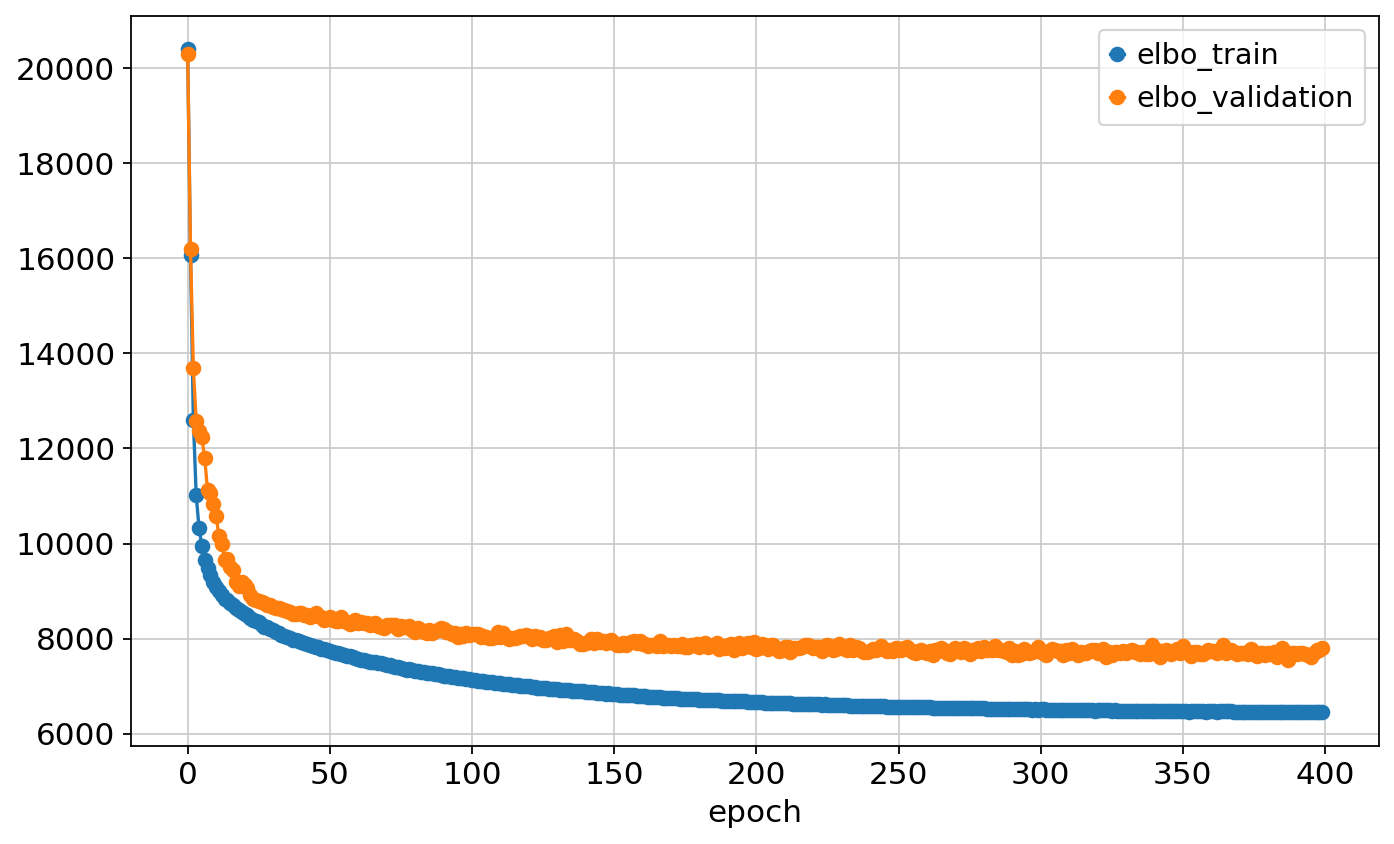

In [16]:
pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line(marker='o')

In [17]:
# fig, ax = plt.subplots(1, 12, figsize=[25, 4])
# for idx, key in enumerate(vae.history.keys()):
#     vae.history[key].plot(title=key, ax=ax[idx])

In [18]:
adata.obsm["X_scVI"] = vae.get_latent_representation(adata)
adata.obsm["X_mde_scVI"] = mde(adata.obsm["X_scVI"])

adata.layers['scVI_normalized'] = vae.get_normalized_expression(return_numpy=True)

In [19]:
vae.save("../results/02_human_integration/scvi", overwrite=True, save_anndata=True)

## 2. SCANVI

In [20]:
lvae = scvi.model.SCANVI.from_scvi_model(
    vae,
    adata=adata,
    labels_key="ct",
    unlabeled_category="Unknown",
)
lvae

ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

In [21]:
max_epochs_scanvi = int(np.min([10, np.max([2, round(200 / 3.0)])]))
print(max_epochs_scanvi)

lvae.train(max_epochs=15)

10

INFO     Training for 15 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 15/15: 100%|███████████████████| 15/15 [00:05<00:00,  2.91it/s, v_num=1, train_loss_step=6.7e+3, train_loss_epoch=6.53e+3]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 15/15: 100%|███████████████████| 15/15 [00:05<00:00,  2.74it/s, v_num=1, train_loss_step=6.7e+3, train_loss_epoch=6.53e+3]


In [22]:
# fig, ax = plt.subplots(3, 3, figsize=[20, 14])
# for idx, key in enumerate(lvae.history.keys()):
#     lvae.history[key].plot(title=key, ax=ax[idx // 3 , idx % 3])

In [23]:
adata.obsm["X_scANVI"] = lvae.get_latent_representation(adata)
adata.obsm["X_mde_scANVI"] = mde(adata.obsm["X_scANVI"])

adata.layers['scANVI_normalized'] = lvae.get_normalized_expression(return_numpy=True)

In [24]:
lvae.save("../results/02_human_integration/scanvi", overwrite=True, save_anndata=True)

## 3. scGEN

In [25]:
import scgen

In [26]:
scgen.SCGEN.setup_anndata(adata, batch_key="batch", labels_key="ct")

In [27]:
mscgen = scgen.SCGEN(adata)

In [28]:
mscgen.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=20,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 29/100:  29%|██████▉                 | 29/100 [00:13<00:33,  2.10it/s, v_num=1, train_loss_step=50.1, train_loss_epoch=45]
Monitored metric elbo_validation did not improve in the last 20 records. Best score: 698.829. Signaling Trainer to stop.


<Axes: xlabel='epoch'>

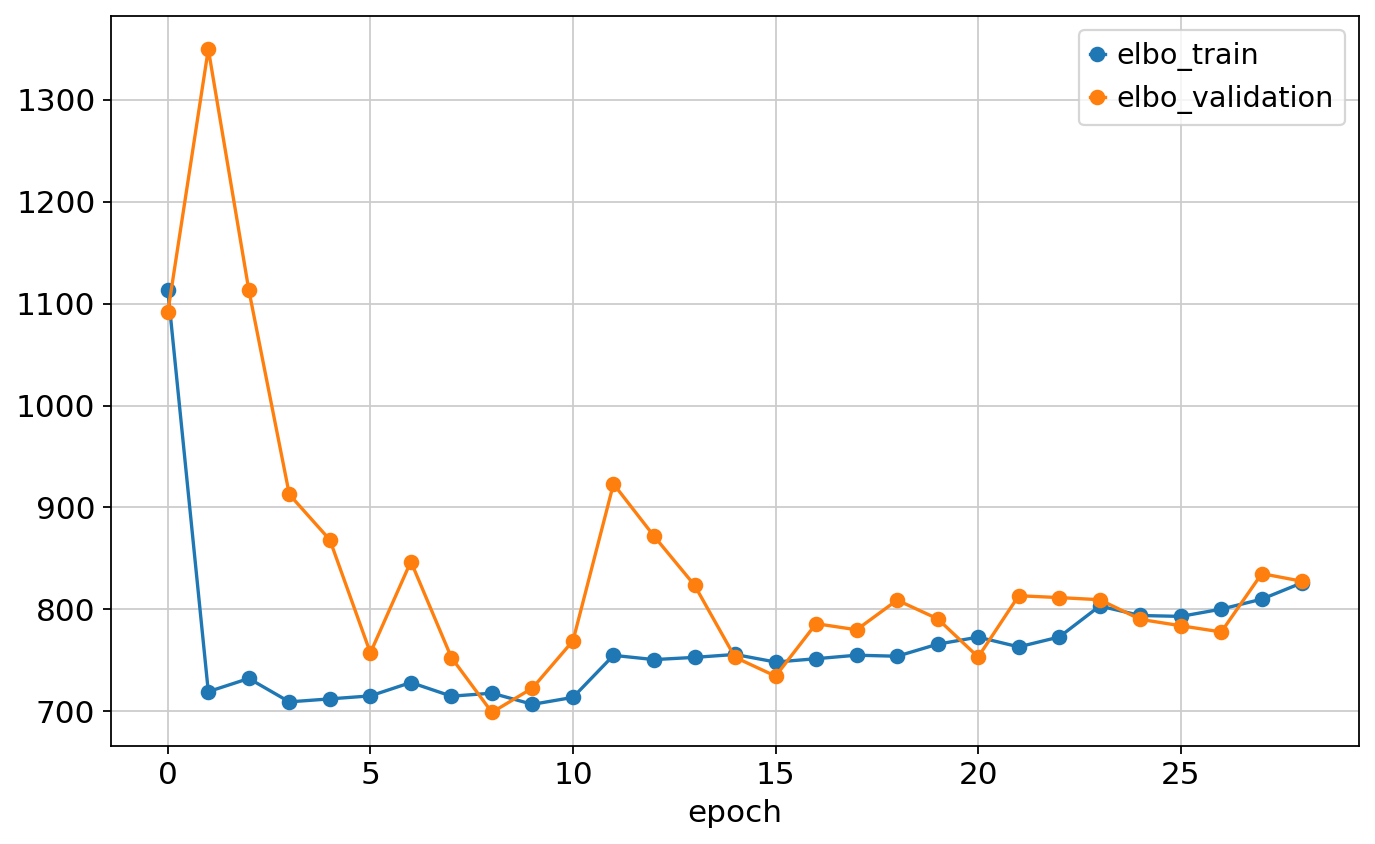

In [29]:
pd.concat([mscgen.history['elbo_train'], mscgen.history['elbo_validation']], axis=1).plot.line(marker='o')

In [30]:
adata.obsm["X_scgen"] = mscgen.batch_removal().obsm['corrected_latent']
adata.obsm["X_mde_scgen"] = mde(adata.obsm["X_scgen"])

adata.layers['scgen_decoded_expr'] = mscgen.get_decoded_expression()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [31]:
mscgen.save("../results/02_human_integration/scgen", overwrite=True, save_anndata=True)

## 4. Stats

Computing neighbors:   0%|                                                                                | 0/4 [00:00<?, ?it/s]/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/fdb589/projects/data/Brickman/conda/envs/scvi-1.0.0/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/dep

INFO     Late epiblast consists of a single batch or is too small. Skip.                                           
INFO     Trophectoderm_10.0 consists of a single batch or is too small. Skip.                                      
INFO     Trophectoderm_8.0 consists of a single batch or is too small. Skip.                                       
INFO     Trophectoderm_9.0 consists of a single batch or is too small. Skip.                                       



Metrics:   0%|                                                                                           | 0/10 [00:00<?, ?it/s]
                                                                                                                                
Metrics:  60%|█████████████████████████████▍                   | 6/10 [00:03<00:02,  1.45it/s, Batch correction: kbet_per_label]

INFO     Late epiblast consists of a single batch or is too small. Skip.                                           
INFO     Trophectoderm_10.0 consists of a single batch or is too small. Skip.                                      
INFO     Trophectoderm_8.0 consists of a single batch or is too small. Skip.                                       
INFO     Trophectoderm_9.0 consists of a single batch or is too small. Skip.                                       



Metrics:   0%|                                                                                           | 0/10 [00:00<?, ?it/s]
                                                                                                                                
Metrics:  60%|█████████████████████████████▍                   | 6/10 [00:01<00:01,  3.86it/s, Batch correction: kbet_per_label]

INFO     Late epiblast consists of a single batch or is too small. Skip.                                           
INFO     Trophectoderm_10.0 consists of a single batch or is too small. Skip.                                      
INFO     Trophectoderm_8.0 consists of a single batch or is too small. Skip.                                       
INFO     Trophectoderm_9.0 consists of a single batch or is too small. Skip.                                       



Metrics:   0%|                                                                                           | 0/10 [00:00<?, ?it/s]
                                                                                                                                
Metrics:  60%|█████████████████████████████▍                   | 6/10 [00:03<00:02,  1.40it/s, Batch correction: kbet_per_label]

INFO     Late epiblast consists of a single batch or is too small. Skip.                                           
INFO     Trophectoderm_10.0 consists of a single batch or is too small. Skip.                                      
INFO     Trophectoderm_8.0 consists of a single batch or is too small. Skip.                                       
INFO     Trophectoderm_9.0 consists of a single batch or is too small. Skip.                                       



Embeddings: 100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.55s/it]

                                                                                                                                

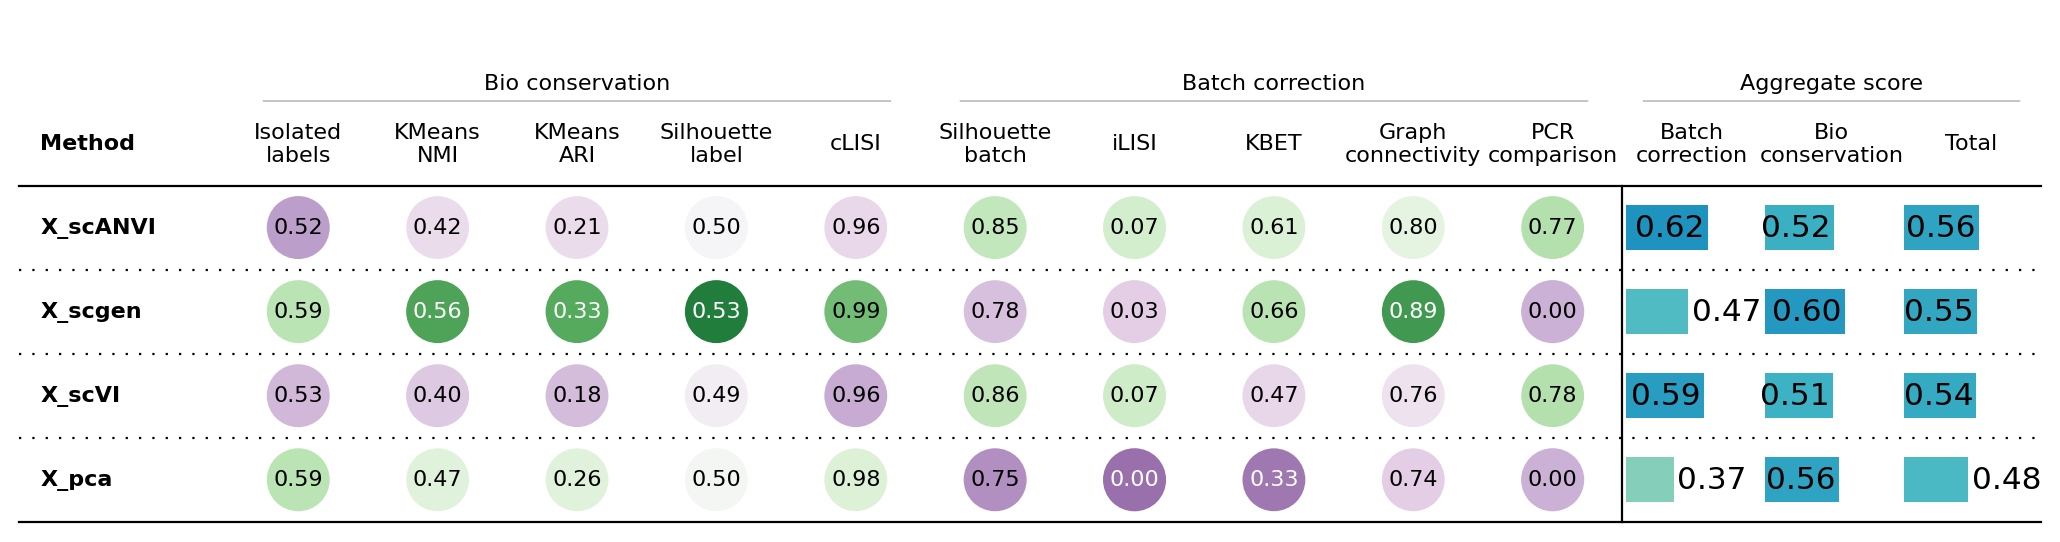

In [32]:
bm = Benchmarker(
    adata,
    batch_key="batch",
    label_key="ct",
    embedding_obsm_keys=["X_pca", "X_scVI", "X_scANVI", "X_scgen"],
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False, save_dir='../results/02_human_integration/')

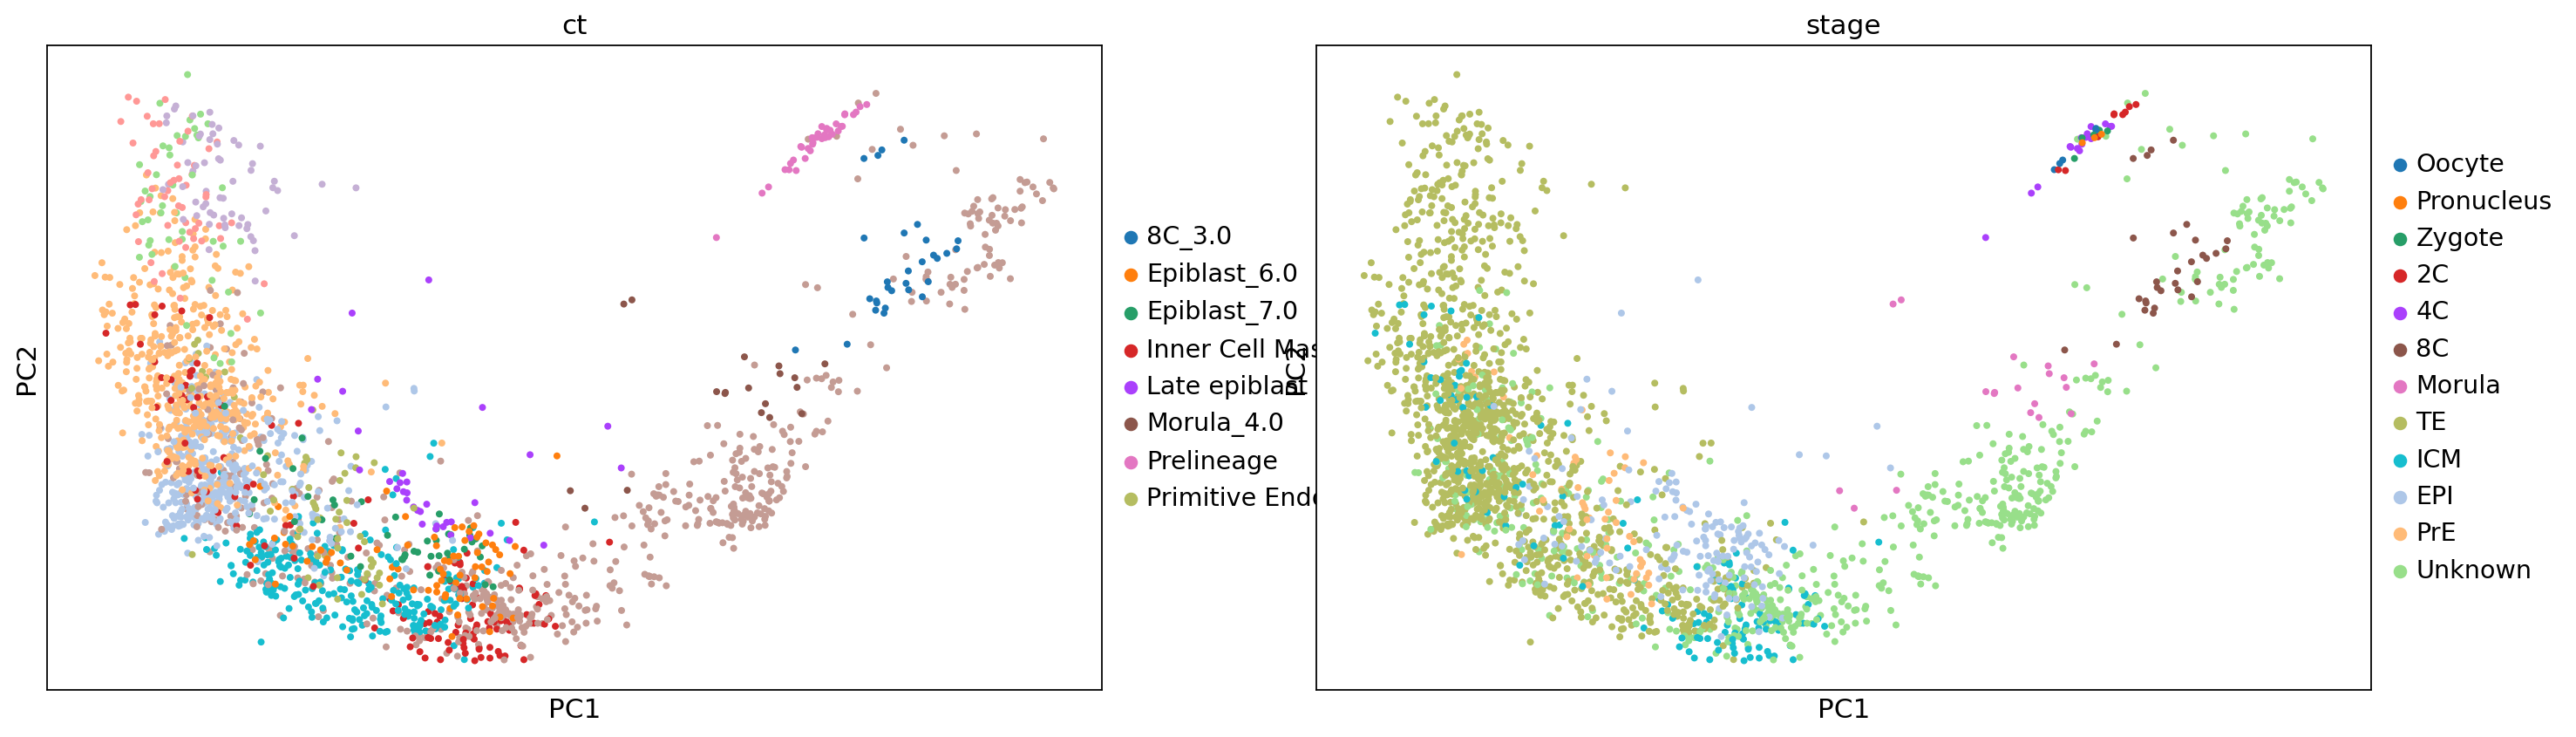

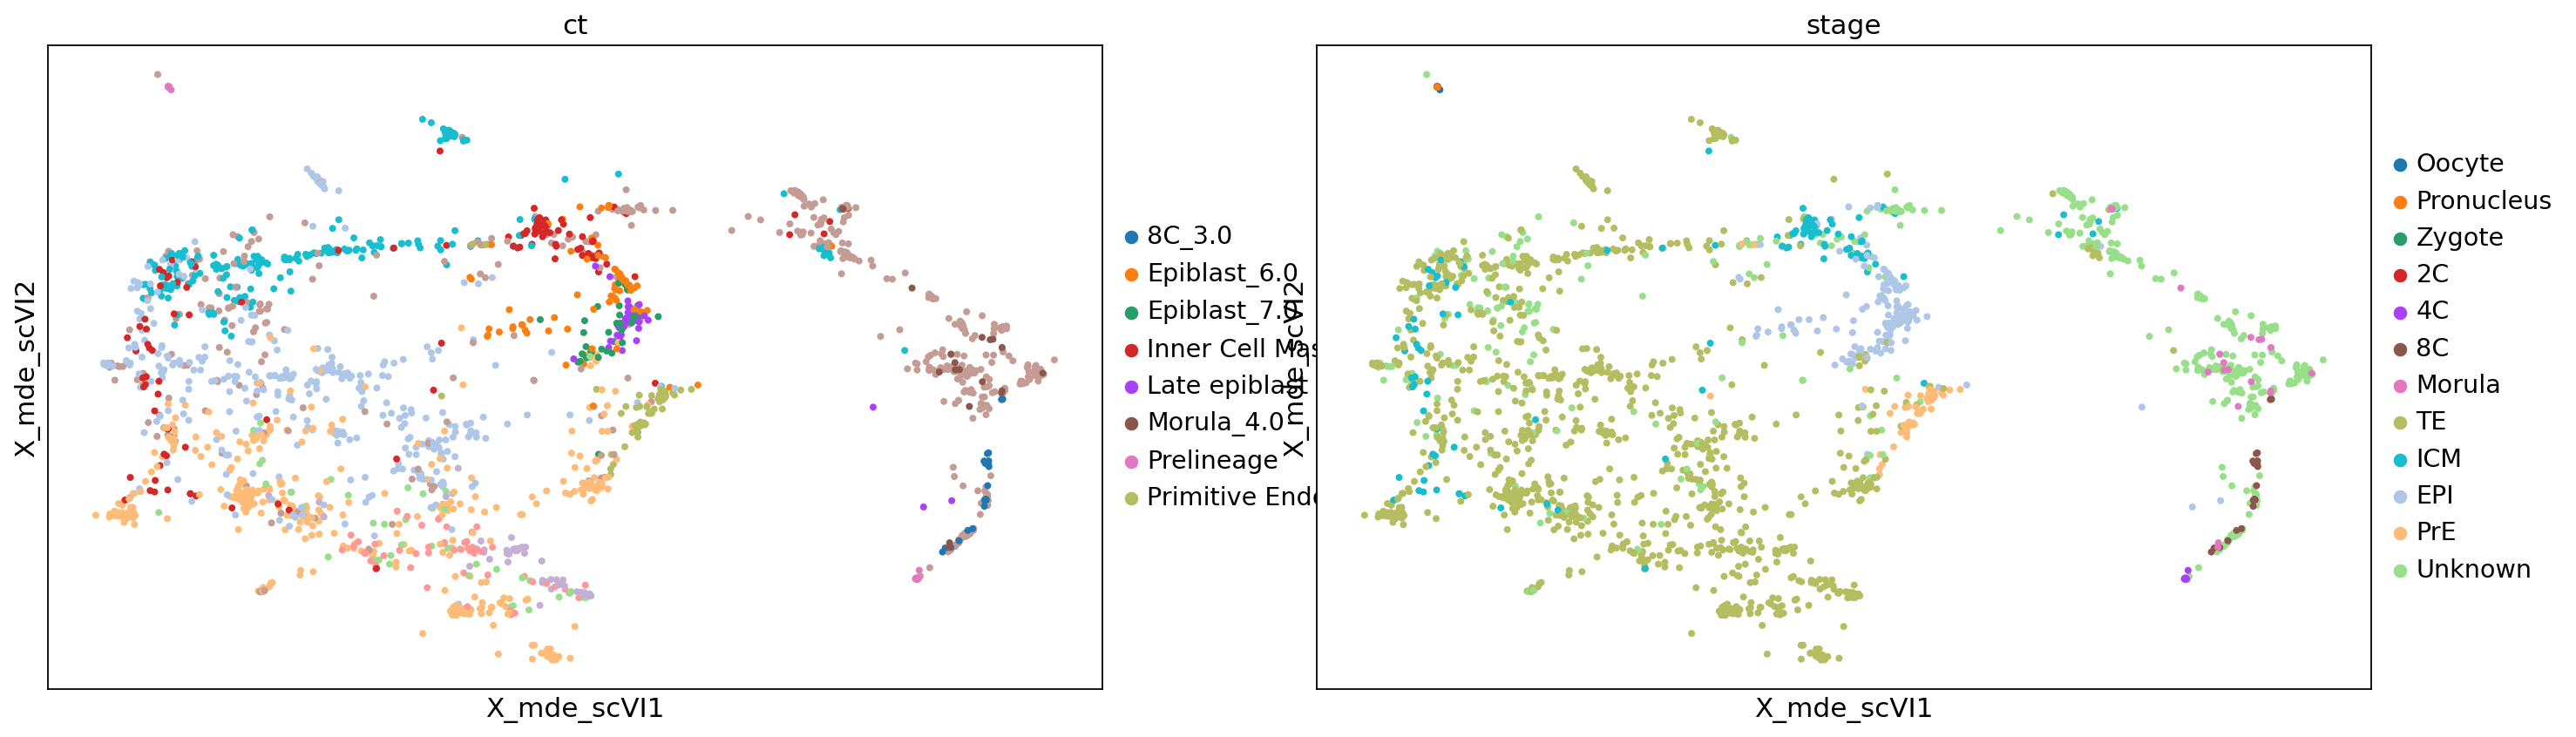

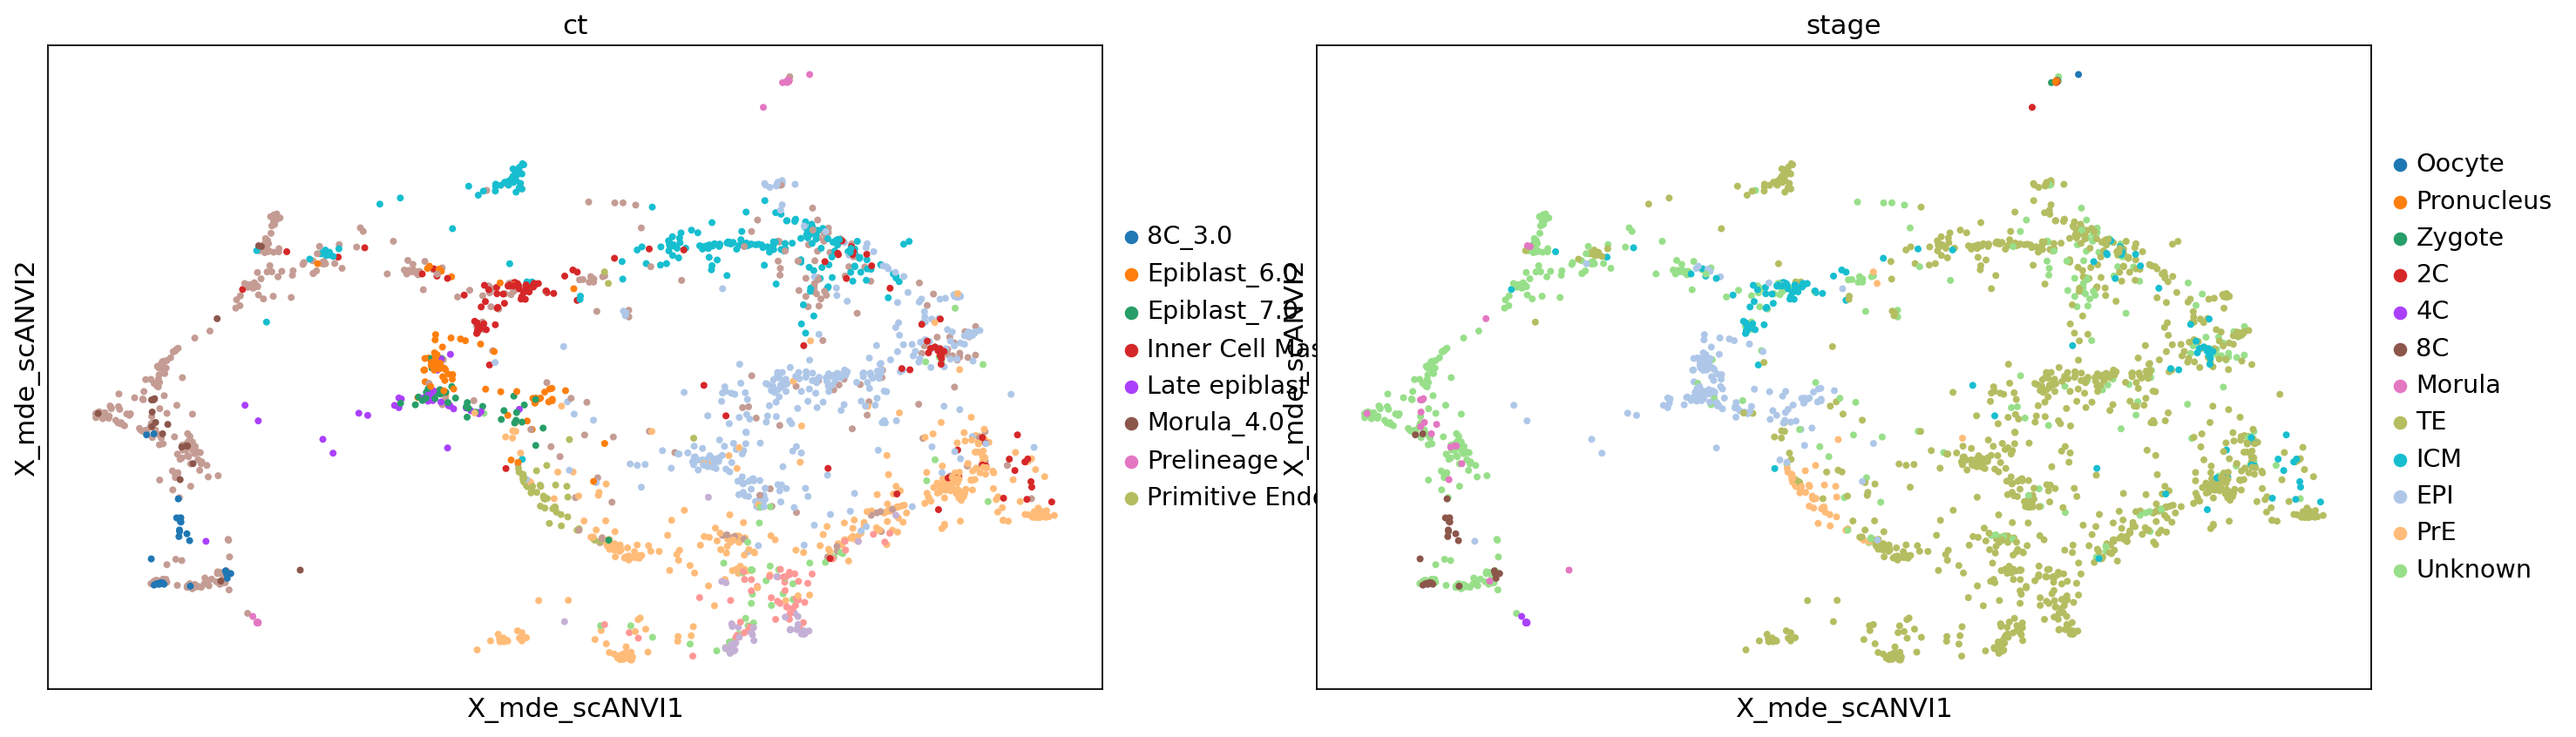

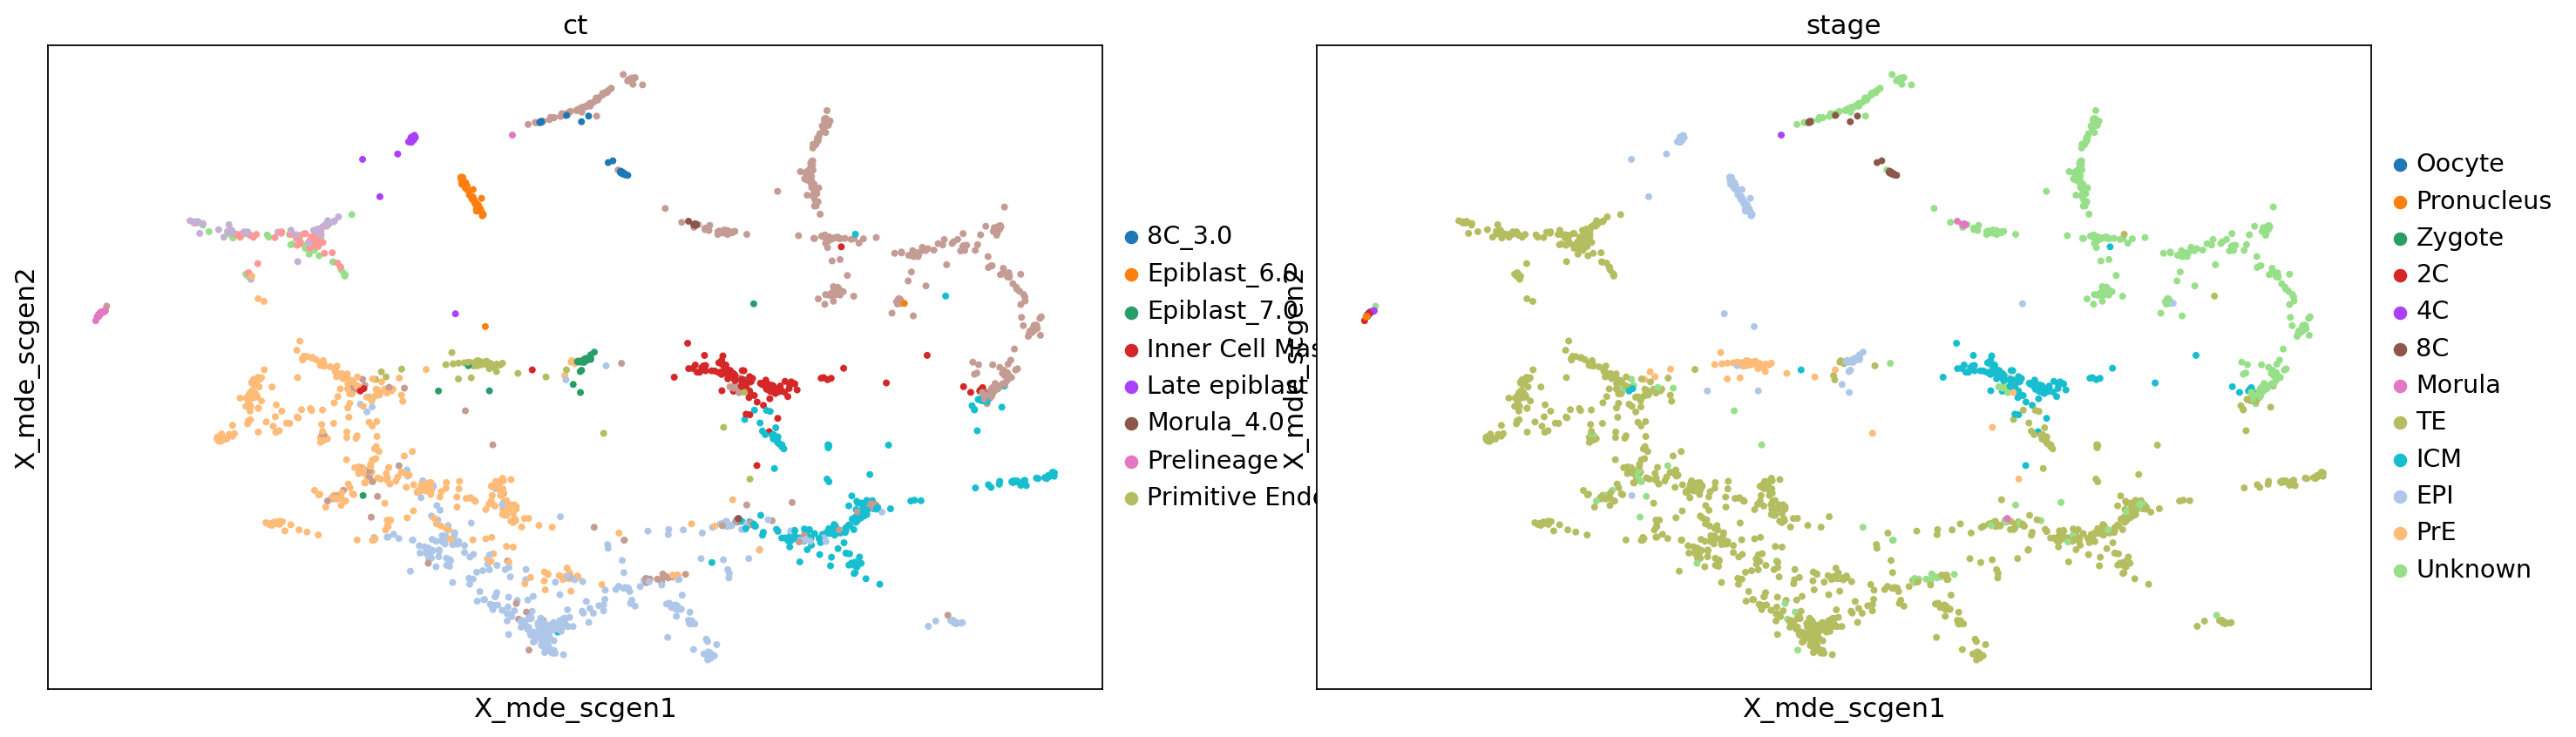

In [33]:
sc.pl.pca(adata, color=['ct', 'stage'])
sc.pl.embedding(adata, color=['ct', 'stage'], basis='X_mde_scVI')
sc.pl.embedding(adata, color=['ct', 'stage'], basis='X_mde_scANVI')
sc.pl.embedding(adata, color=['ct', 'stage'], basis='X_mde_scgen')